In [1]:
%matplotlib inline
import os
import csv
import regex
import pickle
import pymystem3
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree

In [2]:
from tqdm import tqdm_notebook
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
token_regexp = regex.compile("(?u)\\b(\\p{L}+|\d+)\\b")

def tokenize(text):
    return token_regexp.findall(text)

In [4]:
stemmer = pymystem3.Mystem()

add_unparsed = True
gr_regexp = regex.compile("[^\w]")

def lemmatize(tokens):
    lemmas = []
    tokens_str = " ".join(tokens)
    for res in stemmer.analyze(tokens_str):
        if res.get("analysis"):
            info = res["analysis"][0]
            #stem_pos, *_ = gr_regexp.split(info["gr"].upper())
            #lemmas.append("%s_%s" % (info["lex"], mystem_to_uni_map.get(stem_pos, "X")))
            lemmas.append(info["lex"].strip())
        elif add_unparsed:
            lemmas.append(res["text"].strip())
    return list(filter(None, lemmas))

In [5]:
data_dir = "../data/text_alignment/"
task_name = ""

In [6]:
%%time

sentences = {}
files_sentences_ids = {}
sents_cnt = 0
paths = collections.OrderedDict()

with open(data_dir + "tasks/%s/pairs" % task_name) as fin:
    for line in fin:
        susp_name, src_name = line.strip().split()
        paths["susp/" + susp_name] = 1
        paths["src/" + src_name] = 1

paths = list(paths.keys())

for path in tqdm_notebook(paths):
    need_to_continue = False
    lines = []
    with open(data_dir + path) as file:
        for line in file:
            line = line.strip().lower()
            tokens = tokenize(line)
            lines.append(tokens)
    sentences[path] = []
    files_sentences_ids[path] = []
    for i, line in enumerate(lines):
        if line:
            lemmas = lemmatize(line)
            files_sentences_ids[path].append((sents_cnt, i))
            sentences[path].append(lemmas)
            sents_cnt += 1


CPU times: user 5min 18s, sys: 21.1 s, total: 5min 39s
Wall time: 25min 10s


## Train

In [8]:
%%time

with open("dialog_train_texts.csv") as csv_file, open("dialog.starspace.train.txt", "w") as out_train_file:
    header = csv_file.readline().strip().split(",")
    header[0] = "id"
    csv_reader = csv.DictReader(csv_file, header)
    for row in tqdm_notebook(csv_reader):
        susp_text = lemmatize(tokenize(row["suspicious_text"].strip().lower()))
        src_text = lemmatize(tokenize(row["source_text"].strip().lower()))
        out_train_file.write("%s\t%s\n" % (" ".join(susp_text), " ".join(src_text)))

CPU times: user 1min 32s, sys: 4.45 s, total: 1min 37s
Wall time: 8min 38s


In [ ]:
%%time

!./starspace train -trainFile dialog.starspace.train.txt -model dialog.starspace.train -trainMode 3 \
  -initRandSd 0.01 -adagrad true -ngrams 2 -lr 0.025 -epoch 5 -thread 2 -dim 100 \
  -negSearchLimit 10 -fileFormat labelDoc -similarity "cosine" -minCount 2

## How well train set is fit

In [10]:
%%time

# Read Starspace embeddings.

ss_embeddings = {}

with open("starspace.train.tsv") as tsv_file:
    tsv_reader = csv.reader(tsv_file, delimiter="\t")
    for row in tsv_reader:
        word, *vec = row
        vec = np.array(list(map(float, vec)))
        ss_embeddings[word] = vec

CPU times: user 845 ms, sys: 12 ms, total: 857 ms
Wall time: 861 ms


In [11]:
zero_vec = np.zeros(100)

def sentence_to_vec(lemmas, embeddings):
    words = list(filter(embeddings.__contains__, lemmas))
    vs = [zero_vec] + list(map(embeddings.__getitem__, words))
    vec = np.sum(vs, axis=0)
    return vec

In [16]:
%%time

sentences_cnt = 0
sentences_list = []
sentences_pairs_list = []

with open("train_texts.csv") as csv_file:
    header = csv_file.readline().strip().split(",")
    header[0] = "id"
    csv_reader = csv.DictReader(csv_file, header)
    for row in tqdm_notebook(csv_reader):
        susp_text = lemmatize(tokenize(row["suspicious_text"].strip().lower()))
        src_text = lemmatize(tokenize(row["source_text"].strip().lower()))
        sentences_list.append(sentence_to_vec(susp_text, ss_embeddings))
        sentences_list.append(sentence_to_vec(src_text, ss_embeddings))
        sentences_pairs_list.append((sentences_cnt, sentences_cnt + 1))
        sentences_cnt += 2


CPU times: user 5.03 s, sys: 291 ms, total: 5.32 s
Wall time: 19.7 s


In [17]:
negative_sample_size = 100

In [80]:
%%time

np.random.seed(1)

clf_train = []
results_list = []

for sentence_pair in tqdm_notebook(sentences_pairs_list):
    question_id = sentence_pair[0]
    question = sentences_list[question_id]
    positive_sample_id = sentence_pair[1]
    positive_sample = sentences_list[positive_sample_id]
    negative_samples_ids = set()
    while True:
        sample_id = np.random.choice(len(sentences_list))
        if sample_id not in negative_samples_ids and sample_id not in sentence_pair:
            negative_samples_ids.add(sample_id)
        if len(negative_samples_ids) == negative_sample_size:
            break
    negative_samples = list(map(sentences_list.__getitem__, negative_samples_ids))
    dists = 1 - cosine_similarity([question], [positive_sample] + negative_samples)[0]
    ranks = sorted(range(len(dists)), key=dists.__getitem__)
    res = ranks.index(0)
    results_list.append(res)
    for x, y in zip(dists, np.array(ranks) == 0):
        clf_train.append((x, y))


CPU times: user 1min 17s, sys: 155 ms, total: 1min 17s
Wall time: 21.7 s


In [19]:
ks = [1, 5, 10]
results_all_ranks = np.array(results_list)

print("Mean ranking: %.3f" % np.mean(results_all_ranks))

for k in ks:
    ndcg = np.mean(1 / np.log2(np.where(results_all_ranks <= k - 1, results_all_ranks, np.inf) + 2))
    hits = len(results_all_ranks[results_all_ranks <= k - 1]) / len(results_all_ranks)
    print("nDCG@%2d: %.3f | Hits@%2d: %.3f" % (k, ndcg, k, hits))

Mean ranking: 0.158
nDCG@ 1: 0.974 | Hits@ 1: 0.974
nDCG@ 5: 0.987 | Hits@ 5: 0.996
nDCG@10: 0.987 | Hits@10: 0.997


### Error analysis

In [23]:
def show_texts(plag_id):
    obj = test_df.loc[plag_id]
    print("Plagiat type:", obj["obfuscation"])
    print("susp/" + obj["suspicious_path"] + " : " + repr(obj["suspicious_text"]))
    print("src/"+ obj["source_path"] + " : " + repr(obj["source_text"]))

## How well text alignment performs

In [501]:
%%time

!./sent2vec print-sentence-vectors sent2vec.bin < sent2vec.train.txt > vectors.txt

CPU times: user 255 ms, sys: 51 ms, total: 306 ms
Wall time: 9.64 s


In [12]:
%%time

all_vectors = []

for path in paths:
    for lemmas in sentences[path]:
        all_vectors.append(sentence_to_vec(lemmas, ss_embeddings))

all_vectors = np.array(all_vectors)

CPU times: user 3.26 s, sys: 47 ms, total: 3.31 s
Wall time: 3.31 s


In [82]:
clf_train_df = pd.DataFrame(clf_train, columns=["sent2vec_dist", "y"])

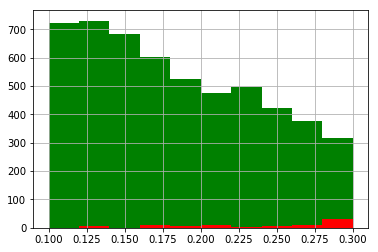

In [84]:
clf_train_df[clf_train_df["y"] == 1]["sent2vec_dist"].hist(color="g", range=(0.1, 0.3))
clf_train_df[clf_train_df["y"] == 0]["sent2vec_dist"].hist(color="r", range=(0.1, 0.3))

In [72]:
%%time

threshold = 0.2
detections = []

for line in tqdm_notebook(open("tasks/pairs")):
    all_metrics = []
    ijs = []
    ds = []
    susp_file, src_file = line.split()
    susp_path = os.path.join("susp", susp_file)
    src_path = os.path.join("src", src_file)
    susp_lens = np.cumsum([0] + list(map(len, open(susp_path).readlines())))
    src_lens = np.cumsum([0] + list(map(len, open(src_path).readlines())))
    susp_ids = files_sentences_ids[susp_path]
    src_ids = files_sentences_ids[src_path]
    susp_vectors = all_vectors[min(susp_ids)[0]:max(susp_ids)[0] + 1]
    src_vectors = all_vectors[min(src_ids)[0]:max(src_ids)[0] + 1]
    sim = 1 - cosine_similarity(susp_vectors, src_vectors)
    for i2, j2 in zip(*np.where(sim < threshold)): # TODO: rework this idea completely !!!
        i = susp_ids[i2][1]
        j = src_ids[j2][1]
        #print(i, j)
        #print(sentences[susp_path][i])
        #print(sentences[src_path][j])
        #print(sim[i2][j2])
        ds.append(((src_lens[j], src_lens[j + 1] - 1), (susp_lens[i], susp_lens[i + 1] - 1)))
    detections.append(ds)


CPU times: user 3.62 s, sys: 249 ms, total: 3.87 s
Wall time: 1.24 s


In [75]:
%time pickle.dump(detections, open("detections.dump", "wb"))

CPU times: user 174 ms, sys: 1e+03 µs, total: 175 ms
Wall time: 175 ms


---